### The Residency Match and Scramble
The main residency match is a process where medical school graduates apply for positions in residency programs, which are required for specialization in medicine. Applicants rank their preferred programs, and residency programs rank the applicants they wish to offer positions to. The match is then conducted using an algorithm by the National Resident Matching Program (NRMP), which pairs applicants with programs based on these rankings. However, not all applicants are matched to a position due to the high competition. If this occurs, they enter the SOAP (Supplemental Offer and Acceptance Program), a "scramble" period, where unmatched applicants can apply for unfilled positions through an intense and expedited process. Applicants only learn which specialty programs have unfilled positions after the matching algorithm results are released, which takes months. To address the uncertainty of what options are available during the "scramble," we will use supervised machine learning to predict how many unfilled positions each specialty will have, based on features known prior to the matching algorithm. As a result, applicants will be able to know before the Match Day about the likely number of positions under each specialty type that would be available to them in the “scramble” process, in the case that they are unmatched. 

While final-year students of US medical schools (US seniors) are a large percentage of the Match applicants, they are not the only demographic involved. International medical school and DO school students/graduates also apply for these residency programs and tend to be subject to the SOAP process more often than US seniors.

### Data Importing and Cleaning


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline


In [ ]:
fulldata = pd.read_csv('2024-2015MainResidencyMatchData.csv')
fulldata.head()

# Some of the entries had 0 offered positions and these were removed as they are not relevant to the analysis
fulldata = fulldata[fulldata != '#DIV/0!'].dropna()

#Checking for duplicates, but there are none
print(fulldata.duplicated().sum())

### Original Data Features
Significant Data cleaning and preparation was required before the final csv file of the data was formed. The raw data was obtained from appending data tables together found from the NRMP's yearly reports on the Main Residency Match Data. Combining the datafrom 10 past years made the size of the dataset more favorable to run ML agorithms on it reliably.
The data tables from 2015-2023 consisted of the following attributes:
1. Specialty	
2. No Programs	Positions Offered
3. Unfilled Programs
4. US Senior Applicants
5. Total Applicants
6. No of US Senior Matches
7. No of Total Matches
8. % Filled by US Seniors
9. % Filled Total
10. Ranked Positions by US Seniors
11. Total Ranked Positions

However, the 2024 data table was structured differently, with different attributes but essentially similar information was conveyed. 
In order to combine the information, new features were created and others removed, leading to the fnialized engineered data as seen in the csv file.


### Feature Engineering
The original data included features such as 'No of Total Matches', and '% Filled by Seniors'. However, we want to use the model as an indicator of the number of unfilled positions in each specialty prior without having to rely on the NRMP Matching algorithm, so any data related to post-match metrics got dropped. This left even fewer features remaining, so feature engineering was used to create the following features from existing data:

4. Applicants per Position Ratio =  No of Total Applicants to Specialty / No of Offered Positions for Specialty
5. No Programs for Specialty to All Programs Ratio = No of Programs for Specialty/ Total PGY-1 No of Programs for Given Year
6. US MD Senior Applicants to Total Applicants Ratio = No of Senior Applicants to Specialty / No of Total Applicants to Specialty
7. Avg Program Size (in number of positions) = No of Offered Positions for Specialty / No of Programs for Specialty
8. No of Applications to the Specialty to All Applications Ratio = No of Total Applicants to Specialty/ Total PGY-1 No of Total Applicants for Given Year



The following table outlines the features used to predict or explain the target variable **"Unfilled Positions"**

| **Feature**                                       | **How it was Calculated**                                            | **Intuition/Significance**                                               |
|--------------------------------------------------|---------------------------------------------------------------------|-------------------------------------------------------------------------|
| **1. Specialty**                                  | Specialty                                                           | This feature represents the specific medical specialty under consideration. It's a categorical variable that helps identify which specialty is being analyzed. |
| **2. Unfilled Positions**                         | Target variable to predict                                          | The number of positions that remain unfilled in the given specialty. This is the main target of prediction in the machine learning model. |
| **3. No of Offered Positions**                   | Number of Offered Positions for the Specialty                        | This feature measures the supply of positions available for a given specialty. It gives an idea of how many positions are being offered for that specialty in a given year. |
| **4. No of Total Applicants**                    | Number of Total Applicants to the Specialty                          | This feature indicates the demand for positions in a specialty, representing how many applicants are interested in that specialty. |
| **5. Applicants per Position Ratio**              | Number of Total Applicants to Specialty / Number of Offered Positions for Specialty | This ratio shows the competitiveness of positions in the specialty. A higher ratio indicates more applicants per available position, suggesting higher competition. |
| **6. No Programs for Specialty to All Programs Ratio** | Number of Programs for Specialty / Total PGY-1 Number of Programs for the Given Year | This ratio shows the "commonness" of a specialty. A higher ratio means the specialty is more common (more programs available), while a lower ratio suggests it is rarer. |
| **7. US MD Senior Applicants to Total Applicants Ratio** | Number of Senior Applicants to Specialty / Number of Total Applicants to Specialty | This feature indicates the desirability of the specialty. A higher ratio means more senior US MD applicants are applying, which indicates a more sought-after specialty (US MD applicants are generally preferred by residency programs to other types of applicants so have a competitive advantage). |
| **8. Avg Program Size (in number of positions)** | Number of Offered Positions for Specialty / Number of Programs for Specialty | This feature reflects the average size of programs within the specialty. Larger average program sizes may indicate greater opportunities for applicants to match. |
| **9. No of Applications to the Specialty to All Applications Ratio** | Number of Total Applicants to Specialty / Total PGY-1 Number of Total Applicants for the Given Year | This ratio measures the popularity of a specialty. A higher ratio indicates that the specialty is more popular compared to others because it received relatively more applications. |
| **10. Year**                                       | Year                                                                | This is simply the year of the data. It may help capture trends or changes in patterns related to unfilled positions over the time frame of 2015 to 2024. |




## Data Exploration

In [ ]:
print(fulldata.shape)
data= fulldata[~fulldata['Specialty'].str.contains('Total PGY-1')] # is not a real specialty, just a total row for the year
print(data.shape)
print('Number of Specialties',len(data['Specialty'].unique()))
data = pd.get_dummies(data, columns=['Specialty', 'Year']) # One hot encoding the specialties and years as they are categorical

data.describe()

In [ ]:
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

print(data.shape) # 10 original columns, -1 Specialty, + 54 dummy Specialties, -1 Year, + 10 dummy Years = 72 columns now
avoid = set(['Specialty', 'Year', 'Unfilled Positions'])
data_without_specialty_or_year=data.drop(columns=[col for col in data.columns if 'Specialty' in col or 'Year' in col], inplace=False)
correlation_data=data.drop(columns=[col for col in data.columns if 'Specialty_' in col or 'Year_' in col or 'Unfilled Positions' in col], inplace=False)

scaler = MinMaxScaler()
correlations = pd.DataFrame(scaler.fit_transform(correlation_data), columns=correlation_data.columns).corr()

plt.figure(figsize=(10, 5))
sns.heatmap(correlations, annot=True, fmt=".2f", cmap='coolwarm')
plt.xlabel('Features')
plt.ylabel('Features')
plt.title('HeatMap for Correlation Matrix')
plt.show()



The correlation is not close enough to +/-1 between any two variables that they would be obviously redundant, except for No of Total Applicants and No of Offered Positions. However, considering how likely both of these features are to be important in predicting the target variable, it is best to keep them both.

In [ ]:
# Drop 'No of Applications to Specialty to All Applications Ratio' as it's correlations with the other features are almost the exact same as 'No of Total Applications'
data = data.drop(columns=['No of Applications to Specialty to All Applications Ratio']) 

In [ ]:
correlations = correlations.stack()
correlations = correlations.reset_index()
correlations.columns = ['feature_1', 'feature_2', 'correlation']

correlations = correlations.query('feature_1 != feature_2')
print ( correlations.iloc[correlations['correlation'].abs().argsort()[::-1]].head(20) )

In [ ]:
data_without_specialty_or_year.plot.scatter(x='No of Offered Positions', y='No of Total Applicants')
plt.show()

These two factors were very similar in the correlation matrix, and we decided to keep them, but this graph is just to confirm that there is some variation which we believe justifies keeping in both features. 

In [ ]:
data_without_specialty_or_year.plot.scatter(x='No of Offered Positions', y='Unfilled Positions')
plt.show()

We wanted to explore if the number of positions offered is linked to unfilled positions. If offering more positions consistently results in more unfilled spots, it could indicate that demand is not keeping pace with supply. However, we can see that while there is a general link on the low endd as the number of unfilled positions cannot exceed the number of offered positions, we can see that in the higher range no direct link can be found. There are some clusters which may be related to specialty, but it is hard to say. 

In [ ]:
data_without_specialty_or_year.plot.scatter(x='No of Total Applicants', y='Unfilled Positions')
plt.show()

We wanted to explore if the number of positions offered is linked to the number of total applicants to once again see if the number of unfilled positions was once again a result of inadequate demand. This graph ends up looking very similar to the previous graph likely due to the strong correlation between the number of total applicants and number of offered positions. 

In [ ]:
data_without_specialty_or_year.plot.scatter(x='Applicants per Position Ratio', y='Unfilled Positions')
plt.xticks([])
plt.show()


We now wanted to look at the ratios to try and see if a trend started to show itself if we ignored the absolute numbers for demand. However, there is still not a clear relationship between the two features. It does show that there is some consistency in the number of Applicants per Position, regardless of the outcome of unfilled positinos

In [ ]:
data_without_specialty_or_year.plot.scatter(x='US MD Senior Applicants to Total Applicants Ratio', y='Unfilled Positions')
plt.show()

We wanted to see if senority had any impact on the number of unfilled positions. We predicted that the if the Senior Applicants Ratio is higher than we would see fewer unfilled positions. This ends up being exactly what we see. 

In [ ]:
data_without_specialty_or_year.plot.scatter(x='Avg Program Size', y='Unfilled Positions')
plt.show()

We wanted to check if there was a link between the Average Program Size and the Number of Unfilled Positions. We expected smaller programs to have fewer unfilled positions which is indeed what we see. Part of this is that obviously the max number of unfilled positions has to be smaller if the program is smaller, but we can also see that many of them have 0 unfilled positions which likely means they are being fully satisfied. We predicted based on the fact that if the program is smaller and more specialized, then anyone is who applying for it is likely to be qualifed enough to be accepted. 

In [ ]:
#bar graph for specialties:
specialty_columns = [col for col in data.columns if 'Specialty_' in col]
print(specialty_columns)
avg_unfilled_positions_per_specialty=[] #the average over the years
for specialty in specialty_columns:
    avg_unfilled_positions_per_specialty.append(data[data[specialty]==True]['Unfilled Positions'].mean())

less_than_10 = [(specialty, avg) for specialty, avg in zip(specialty_columns, avg_unfilled_positions_per_specialty) if avg <= 10]
greater_than_10 = [(specialty, avg) for specialty, avg in zip(specialty_columns, avg_unfilled_positions_per_specialty) if avg > 10]

less_than_10 = reversed(sorted(less_than_10, key=lambda x: x[1]))
greater_than_10 = reversed(sorted(greater_than_10, key=lambda x: x[1]))

specialties_lt_10, values_lt_10 = zip(*less_than_10) if less_than_10 else ([], [])
specialties_gt_10, values_gt_10 = zip(*greater_than_10) if greater_than_10 else ([], [])

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(16, 20))

# Plot for values <= 100
ax1.bar(specialties_lt_10, values_lt_10)
ax1.set_title('Specialties with Avg Unfilled Positions <= 10')
ax1.set_xlabel('Specialty')
ax1.set_ylabel('Average Unfilled Positions')
ax1.set_xticklabels([x.split('_')[1] for x in specialties_lt_10], rotation=90, fontsize=12)

# Plot for values > 100
ax2.bar(specialties_gt_10, values_gt_10)
ax2.set_title('Specialties with Avg Unfilled Positions > 10')
ax2.set_xlabel('Specialty')
ax2.set_ylabel('Average Unfilled Positions')
ax2.set_xticklabels([x.split('_')[1] for x in specialties_gt_10], rotation=90, fontsize=12)

plt.tight_layout()
plt.show()


These histograms aren't very helpful for picking out trends, but are useful for highlighting the large discrepancies in the number of unfilled positions between specialties as well as highlighting and making it easier to parse the predictions and residuals later on. A higher absolute error is more acceptable for specialties with a higher average number of unfilled positions.


In [ ]:

#bar graph for yearly trends
year_totals = fulldata[fulldata['Specialty']=='Total PGY-1']['Unfilled Positions']
years = fulldata[fulldata['Specialty']=='Total PGY-1']['Year']

fig2, ax = plt.subplots(figsize=(8,5))
ax.bar(years, year_totals)
ax.set_title('Unfilled Positions by Year')
ax.set_ylabel('Num Unfilled Positions')
ax.set_xlabel('Year')

plt.show()


The graph for unfilled positions by year shows a clear trend that the number of unfilled positions is increasing which highlights that this is an important feature to consider in the model as the year will definitely have an impact on the number of unfilled positions.


#### Outliers Detection and Removal

We tested with several outlier detection methods, including Z-Score, IQR, DBSCAN, and K-means Clustering for each scatter plot to visually determine which method would fit the data best. We did these tests on each feature's scatterplot, along with hyperparameter tuning, and ultimately found that the isolation forest method performed the best -- it seemed to only remove relevant anomalies without excessive pruning.

However, although it is not reflected in the current scatterplots, by pruning these outliers (which could be extreme applicants or extreme ratios), the remaining data seemed to only include central, less varied observations. The latter scatterplots seemed to have 'rounded' plotpoints due to this, which is why we make a new copy of filtered_data from data_without_specialty_or_year in the shown outlier removal visualizations. 

When compounding feature's outlier removal, it is likely this poorer fitting also affected our MSE and R^^2observations. 

When utilizing our final filtered_data after the shown outlier removal for each feature, our trained models saw a decrease in both MSE and R^2, even despite the numerous tests using different methods of anomaly detection and hyperparameter tuning for each. Thus, the models run below ultimately do not utilize this filtered data. #

In [ ]:
from sklearn.ensemble import IsolationForest

filtered_data = data_without_specialty_or_year.copy()

X = filtered_data[['No of Offered Positions', 'No of Total Applicants']].values

iso_forest = IsolationForest(contamination=0.05) 

filtered_data['outlier'] = iso_forest.fit_predict(X)
filtered_data = filtered_data[filtered_data['outlier'] == 1].drop(columns=['outlier'])

plt.figure(figsize=(10, 6))
plt.scatter(filtered_data['No of Offered Positions'], 
            filtered_data['No of Total Applicants'])
plt.xlabel('No of Offered Positions')
plt.ylabel('No of Total Applicants')
plt.title('No of Offered Positions vs No of Total Applicants after Isolation Forest Outlier Removal')
plt.show()

By pruning the outliers from these columns, we effectively reduced the range of both the total number of applicants and the number of offered positions by approximately half. Similar trends were observed when using Z-Score and IQR methods. After hyperparameter tuning, the outlier detection appeared most effective at this threshold.

In [ ]:
filtered_data = data_without_specialty_or_year.copy()

X = filtered_data[['No of Offered Positions', 'Unfilled Positions']].values

iso_forest = IsolationForest(contamination=0.05) 

filtered_data['outlier'] = iso_forest.fit_predict(X)
filtered_data = filtered_data[filtered_data['outlier'] == 1].drop(columns=['outlier'])

plt.figure(figsize=(10, 6))
plt.scatter(filtered_data['No of Offered Positions'], 
            filtered_data['Unfilled Positions'])
plt.xlabel('No of Offered Positions')
plt.ylabel('Unfilled Positions')
plt.title('No of Offered Positions vs Unfilled Positions after Isolation Forest Outlier Removal')
plt.show()

A similar pattern followed for the number of offered positions as well. When trying different methods, DBSCAN and K-Means were a better fit than Z-Score and IQR due to the cluster nature of this data. When using K-Means = 5, the results were consistent with the results shown here using Isolation Forest. 

In [ ]:
filtered_data = data_without_specialty_or_year.copy()

X = filtered_data[['No of Total Applicants', 'Unfilled Positions']].values

iso_forest = IsolationForest(contamination=0.05) 

filtered_data['outlier'] = iso_forest.fit_predict(X)

filtered_data = filtered_data[filtered_data['outlier'] == 1].drop(columns=['outlier'])

plt.figure(figsize=(10, 6))
plt.scatter(filtered_data['No of Total Applicants'], 
            filtered_data['Unfilled Positions'])
plt.xlabel('No of Total Applicants')
plt.ylabel('Unfilled Positions')
plt.title('No of Total Applicants vs Unfilled Positions after Isolation Forest Outlier Removal')
plt.show()

The results for this plot were very similar to the one above, so we continued using the same method (Isolation Forest) with the same parameter (contamination).

In [ ]:
filtered_data = data_without_specialty_or_year.copy()

X = filtered_data[['Applicants per Position Ratio', 'Unfilled Positions']].values

iso_forest = IsolationForest(contamination=0.05) 

filtered_data['outlier'] = iso_forest.fit_predict(X)

filtered_data = filtered_data[filtered_data['outlier'] == 1].drop(columns=['outlier'])

plt.figure(figsize=(10, 6))
plt.scatter(filtered_data['Applicants per Position Ratio'], 
            filtered_data['Unfilled Positions'])
plt.xlabel('Applicants per Position Ratio')
plt.ylabel('Unfilled Positions')
plt.title('Applicants per Position Ratio vs Unfilled Positions after Isolation Forest Outlier Removal')
plt.show()


Since this plot had linear clusters, we first tried to use DBSCAN and K-Means, but those weren't as effective due to uneven spacing and clusterings of the data. Thus, Isolation Forest again appeared to suit this data best. 

In [ ]:
filtered_data = data_without_specialty_or_year.copy()

X = filtered_data[['US MD Senior Applicants to Total Applicants Ratio', 'Unfilled Positions']].values

iso_forest = IsolationForest(contamination=0.05) 

filtered_data['outlier'] = iso_forest.fit_predict(X)

filtered_data = filtered_data[filtered_data['outlier'] == 1].drop(columns=['outlier'])

plt.figure(figsize=(10, 6))
plt.scatter(filtered_data['US MD Senior Applicants to Total Applicants Ratio'], 
            filtered_data['Unfilled Positions'])
plt.xlabel('US MD Senior Applicants to Total Applicants Ratio')
plt.ylabel('Unfilled Positions')
plt.title('US MD Senior Applicants to Total Applicants Ratio vs Unfilled Positions after Isolation Forest Outlier Removal')
plt.show()

Although this plot had a more central, horizontal cluster the limitations were similar to the previous plot in terms of using DBSCAN or K-Means, so Isolation Forest appeared to be optimal.

In [ ]:
filtered_data = data_without_specialty_or_year.copy()

X = filtered_data[['Avg Program Size', 'Unfilled Positions']].values

iso_forest = IsolationForest(contamination=0.05) 

filtered_data['outlier'] = iso_forest.fit_predict(X)

filtered_data = filtered_data[filtered_data['outlier'] == 1].drop(columns=['outlier'])

plt.figure(figsize=(10, 6))
plt.scatter(filtered_data['Avg Program Size'], 
            filtered_data['Unfilled Positions'])
plt.xlabel('Avg Program Size')
plt.ylabel('Unfilled Positions')
plt.title('Avg Program Size vs Unfilled Positions after Isolation Forest Outlier Removal')
plt.show()

The outlier removal for this plot was more subtle in a pattern similar to the recent plots above. With the current contamination parameter, using Isolation Forest allowed the data to retain some variability without reducing the range of our datapoints quite as drastically as seen in the first few plots.

# Models

In [ ]:
from sklearn.model_selection import train_test_split

# Training / Test data split
data_encoded = data
X = data_encoded.drop(['Unfilled Positions'], axis=1)
y = data_encoded['Unfilled Positions']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Decision Tree Regression
Since the decision trees can split based on the average program size and competitiveness, the decision tree can help seperate out the data point to predict it based on similar previous datapoints.

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

%matplotlib inline

tree = DecisionTreeRegressor()

params = {
    'max_depth': range(1, 21, 2),
    'min_samples_split': range(2, 11, 2),
    'min_samples_leaf': range(1, 11, 2),
    'max_features': range(1, 11),
}

grid = GridSearchCV(estimator=tree, param_grid=params, cv=5, scoring='neg_mean_squared_error')
cross_val_DTR = -1 * cross_val_score(grid, X, y, cv=5, verbose=True)
print(f"Cross Val Score: {cross_val_DTR.mean()}")

In [100]:
print(cross_val_DTR.mean() / len(y))
print(cross_val_DTR / len(y))

25.975355495788605
[34.52011606  7.57551935 26.90786274  0.10599154 60.7672878 ]


### Linear Regression
We used linear regression to identify linear trends between our features like and how it may related to unfilled positions.

In [101]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score

scaler = StandardScaler()
linreg = LinearRegression()
pipeline = make_pipeline(scaler, linreg)

cross_val_LR = -1 * cross_val_score(linreg, X, y, cv=5) 


In [102]:
print(f"Cross Val Score: {cross_val_LR.mean() / len(y)}")
print(cross_val_LR / len(y))

Cross Val Score: 0.07021844526578223
[0.00217156 0.03402529 0.01326363 0.29830942 0.00332232]


### Random Forest Regressor
We used random Forest to aggregate predictions from multiple Decision Trees to improve accuracy while using the most important features impacting unfilled positions.

In [103]:
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor()
params = {
    'n_estimators': range(1, 20, 3),
    'max_depth': range(1, 21, 3),
    'min_samples_leaf': range(1, 11, 2),
    'max_features': range(1, 11, 2)
}

grid = GridSearchCV(estimator=forest, param_grid=params, cv=5, scoring='neg_mean_squared_error')
cross_val_RFR = -1 * cross_val_score(grid, X, y, cv=5)


KeyboardInterrupt: 

In [ ]:
print(f"Cross Val Score: {cross_val_RFR.mean() / len(y)}")
print(cross_val_RFR / len(y))

Cross Val Score: 23.313890921009918
[34.19568521 13.48519652  8.62222925  0.35586805 59.91047558]


### KNN Regressor
We used KNN to find the similarity between specialties, predict unfilled positions based on features of the most similar specialties.

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor()

params = {
    'kneighborsregressor__n_neighbors': range(1, 21),
    'kneighborsregressor__weights': ['uniform', 'distance'],
    'kneighborsregressor__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

scale = StandardScaler()
pipeline = make_pipeline(scale, knn)

grid = GridSearchCV(estimator=pipeline, param_grid=params, cv=5, scoring='neg_mean_squared_error')

cross_val_KNN = -1 * cross_val_score(grid, X, y, cv=5)


In [ ]:
print(f"Cross Val Score: {cross_val_KNN.mean() / len(y)}")
print(cross_val_KNN / len(y))

Cross Val Score: 19.45087699594301
[33.30760034  1.27057199  3.23543885  0.25353235 59.18724145]


### Neural Net
We used the Neural Network to balance out the complex interactions between features, such as competitiveness ratios and yearly trends, to predict unfilled positions with high flexibility.

In [ ]:
# need to first use 5 fold CV to find best hidden layer size and best activation function
# mostly taken straight from assignment 4 and modified
mlp_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPRegressor(max_iter=1000, random_state=22))
])

param_grid = {
    'mlp__hidden_layer_sizes': [(30,), (40,), (50,), (60,)],
    'mlp__activation': ['logistic', 'tanh', 'relu']
}

grid_search = GridSearchCV(
    estimator=mlp_pipeline,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error'
)

cross_val_Nnet = -1 * cross_val_score(grid_search, X, y, cv=5)

In [ ]:
print(f"Cross Val Score: {cross_val_Nnet.mean() / len(y)}")
print(cross_val_Nnet / len(y))

Cross Val Score: 22.130030738797483
[45.2050098   5.712314   10.2455092   4.52924058 44.95808012]


# Comparing Models

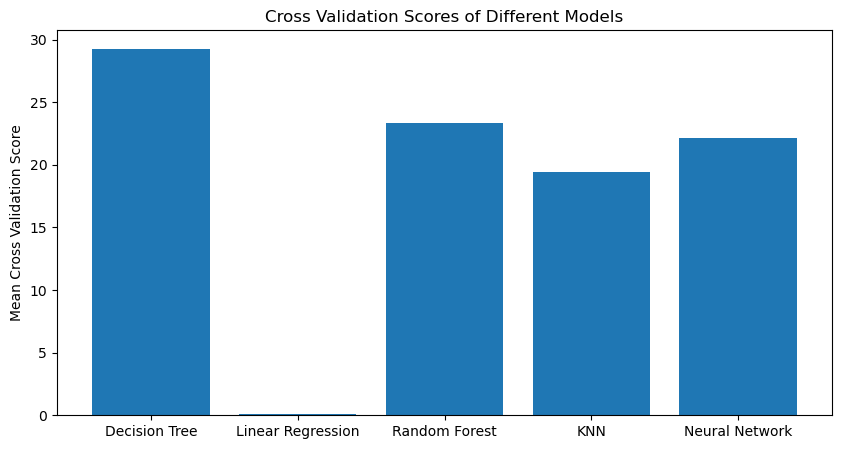

In [ ]:
# Compare and plot the cross-validation scores all of the models

plt.figure(figsize=(10, 5))
Cross_val_scores = [cross_val_DTR.mean() / len(y), cross_val_LR.mean() / len(y), cross_val_RFR.mean() / len(y), cross_val_KNN.mean() / len(y), cross_val_Nnet.mean() / len(y)]
models = ['Decision Tree', 'Linear Regression', 'Random Forest', 'KNN', 'Neural Network']
plt.bar(models, Cross_val_scores)
plt.ylabel('Mean Cross Validation Score')
plt.title('Cross Validation Scores of Different Models')

plt.show()


## Graphing Why Models Are Incorrect
All of the models appeared sufficiently accurate to justify a closer inspection of their prediction errors. To better understand these discrepancies, we reran all the models on a single test-train split and plotted the predicted values against the actual values. This allowed us to visualize where the models were over- or under-predicting and to identify any potential trends in the errors.

In [ ]:
# Linear Regression
linreg_graph = LinearRegression()
linreg_graph.fit(X_train, y_train)
y_test_pred_lr = linreg_graph.predict(X_test)

# Print Corrpesponding Features
for i in range(len(linreg_graph.coef_)):
    print(f'{X.columns[i]}: {linreg_graph.coef_[i]}')


No of Offered Positions: 0.3071426911706867
No of Total Applicants: -0.1377432410686626
Applicants per Position Ratio: -0.4647423295430144
No Programs for Specialty to All Programs Ratio: -2767.3300039695073
US MD Senior Applicants to Total Applicants Ratio: -34.02713050185605
Avg Program Size: -1.179184793839056
Specialty_Anesthesiology: -34.549770463652365
Specialty_Child Neurology: -20.1145682122564
Specialty_Dermatology: -6.428617923336105
Specialty_Emergency Med-Anesthesiology: -44.31326440649079
Specialty_Emergency Med-Family Med: -47.93954923959636
Specialty_Emergency Medicine: -157.7749436087605
Specialty_Family Med-Preventive Med: -46.6513879033775
Specialty_Family Medicine: 261.1945370702696
Specialty_Family Medicine-ONMM: -66.74300566628357
Specialty_Internal Medicine (Categorical): -233.1904147922902
Specialty_Interventional Radiology (Integrated): -12.233838279652574
Specialty_Medicine-Anesthesiology: -40.88075930752311
Specialty_Medicine-Dermatology: -35.536051644538404
S

In [ ]:
# Decision Tree
DTR = DecisionTreeRegressor()

params = {
    'max_depth': range(1, 21, 2),
    'min_samples_split': range(2, 11, 2),
    'min_samples_leaf': range(1, 11, 2),
    'max_features': range(1, 11),
}

grid_DTR = GridSearchCV(estimator=tree, param_grid=params, cv=5, scoring='neg_mean_squared_error')
grid_DTR.fit(X_train, y_train)
best_DTR = grid_DTR.best_estimator_

y_test_pred_dtr = best_DTR.predict(X_test)

In [ ]:
# Random Forest
RFR = RandomForestRegressor()

params = {
    'n_estimators': range(1, 20, 2),
    'max_depth': range(1, 21, 3),
    'min_samples_leaf': range(1, 11, 2),
    'max_features': range(1, 11, 2)
}

grid_RFR = GridSearchCV(estimator=forest, param_grid=params, cv=5, scoring='neg_mean_squared_error')
grid_RFR.fit(X_train, y_train)
best_RFR = grid_RFR.best_estimator_

y_test_pred_rfr = best_RFR.predict(X_test)

In [ ]:
# KNN
params = {
    'kneighborsregressor__n_neighbors': range(1, 21),
    'kneighborsregressor__weights': ['uniform', 'distance'],
    'kneighborsregressor__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

# Create the pipeline
scale = StandardScaler()
pipeline = make_pipeline(scale, knn)

# Set up GridSearchCV with the correct parameter grid
grid_KNN = GridSearchCV(estimator=pipeline, param_grid=params, cv=5, scoring='neg_mean_squared_error')
grid_KNN.fit(X_train, y_train)
best_KNN = grid_KNN.best_estimator_

y_test_pred_knn = best_KNN.predict(X_test)

In [ ]:
# Neural Network
mlp_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPRegressor(max_iter=1000, random_state=42))
])

param_grid = {
    'mlp__hidden_layer_sizes': [(30,), (40,), (50,), (60,)],
    'mlp__activation': ['logistic', 'tanh', 'relu']
}

# hyperparameter tuning
grid_search = GridSearchCV(
    estimator=mlp_pipeline,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error'
)

grid_search.fit(X_train, y_train)
best_Nnet = grid_search.best_estimator_

y_test_pred_nnet = best_Nnet.predict(X_test)

Model Linear Regression MSE: 393.67948406861876
Model Decision Tree MSE: 1242.1216300075478
Model Random Forest MSE: 1212.8024668909472
Model KNN MSE: 759.9819587628866
Model Neural Network MSE: 901.0130118432896
Model Linear Regression R^2 Score: 0.9653265532628819
Model Decision Tree R^2 Score: 0.8905997393260601
Model Random Forest R^2 Score: 0.8931820340146072
Model KNN R^2 Score: 0.9330643454009846
Model Neural Network R^2 Score: 0.9206429901992218


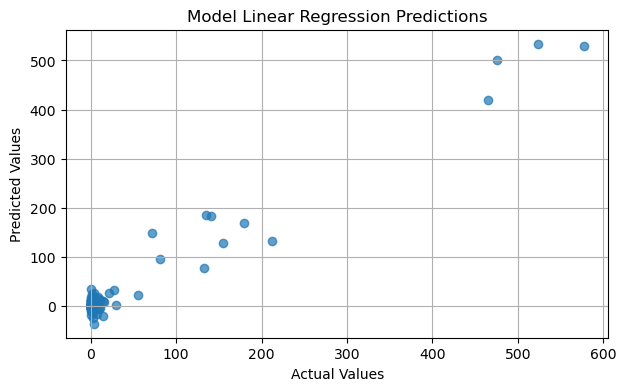

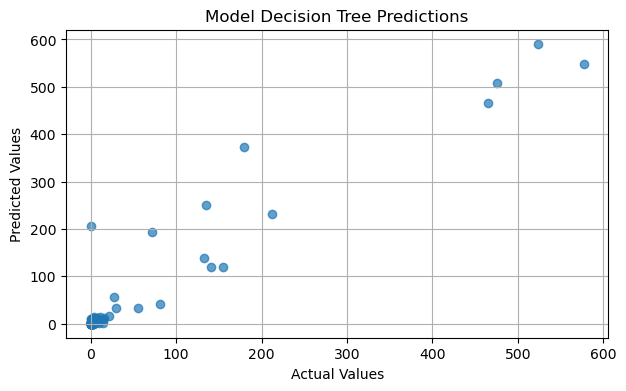

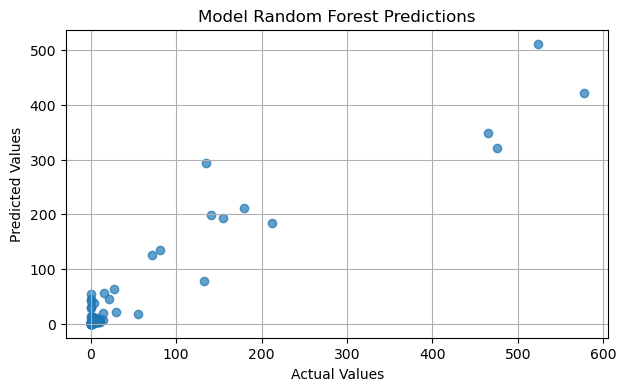

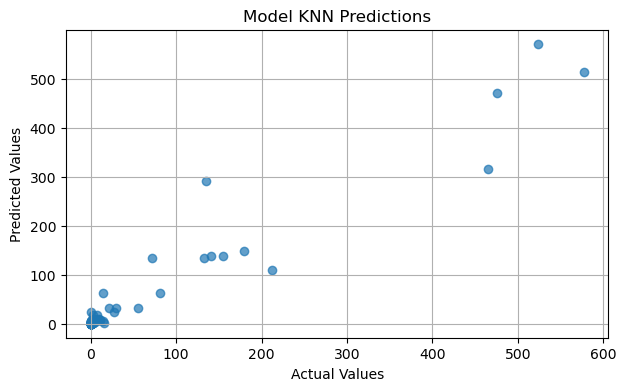

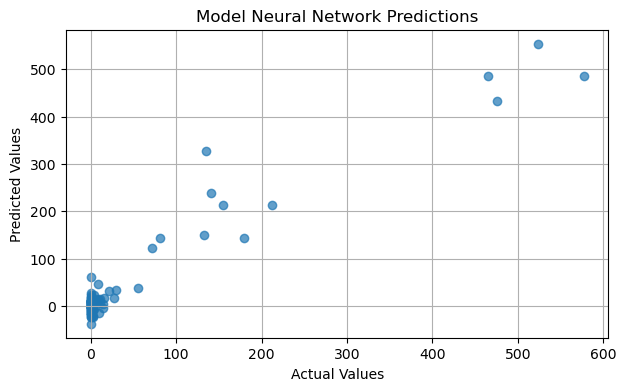

In [ ]:
models = ['Linear Regression', 'Decision Tree', 'Random Forest', 'KNN', 'Neural Network']
model_vals = [y_test_pred_lr, y_test_pred_dtr, y_test_pred_rfr, y_test_pred_knn, y_test_pred_nnet]

for i in range(5):
    print(f"Model {models[i]} MSE: {mean_squared_error(y_test, model_vals[i])}")

for i in range(5):
    print(f"Model {models[i]} R^2 Score: {r2_score(y_test, model_vals[i])}")

for i in range(5):
    plt.figure(figsize=(7, 4))
    plt.scatter(y_test, model_vals[i], alpha=0.7)
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title(f'Model {models[i]} Predictions')
    plt.grid()
    plt.show()


### Conclusion
Linear regression had the lowest mean cross-validation score per entry (<0.1), indicating that it most accurately captures the underlying trends in the data compared to the other models.

Analyzing the coefficients that contributed most to the final prediction, we found that the 'Number of Programs for Specialty to All Programs Ratio' (a measure of the percentage of applicants who applied to a specific specialty relative to the total number of applicants) was by far the most influential factor, with a coefficient of approximately -3200. The next most significant factor was the specific specialty to which applicants were applying. Specialties with the highest number of unfilled positions had the largest coefficients, which aligns with expectations.

Decision Trees and KNNs performed similarly, ranking in the middle of the pack, while Random Forests had the worst performance of all the models we tested. We believe this is because these models rely on averaging values from groups of samples within the dataset. As seen in the Predicted vs. Actual Values graph, these models tend to overestimate on the lower end and underestimate on the higher end. Our dataset includes many specialties with very few offered positions and applicants, as well as a few specialties with a large number of positions and applicants, but there are relatively few data points in between. We suspect that the models are being influenced by outlier values from these two clusters, leading to inaccurate predictions. Additionally, the results from linear regression suggest that only a few features are truly impactful for the final prediction. This implies that decision trees may be overfitting to irrelevant features, further reducing their effectiveness.

The Neural Network performed worse than linear regression but noticeably better than the other models. We believe this is because, like linear regression, the neural network attempts to approximate the underlying function that drives the data, rather than averaging previously observed values. This approach makes it less susceptible to the issues seen with models like Decision Trees and Random Forests.

Overall, we were initially surprised by how well linear regression performed, as we had expected the other models to be more successful. However, after further analysis, the results make sense. With an R^2 value greater than 0.9 between actual and predicted values, we believe the linear regression model could be useful for accurately predicting future outcomes.